In [1]:
# Core data libraries
import pandas as pd
import numpy as np

# Modeling
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# Explainability
import shap

# Saving
import joblib
import json

print("Imports loaded.")


/Users/veerr_89/global/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports loaded.


In [2]:
df = pd.read_csv("data/TurbineGroup2.csv")  # ensure file is in the same folder

print("Shape:", df.shape)
df.head()


Shape: (14310, 11)


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,9.3779,1020.1,90.262,2.3927,19.166,1043.6,541.16,110.16,10.564,9.3472,98.741
1,9.2985,1019.9,89.934,2.3732,19.119,1039.9,538.94,109.23,10.572,11.0160,104.290
2,9.1337,1019.8,89.868,2.3854,19.178,1041.0,539.47,109.62,10.543,10.7500,103.470
3,8.9715,1019.3,89.490,2.3825,19.180,1037.1,536.89,108.88,10.458,12.2870,108.810
4,9.0157,1019.1,89.099,2.4044,19.206,1043.5,541.25,110.09,10.464,9.8229,100.020


In [3]:
df.columns = df.columns.str.strip()

features = ["TIT","TAT","CDP","GTEP","AFDP","AT","AP","AH","TEY"]
target = "NOX"

print("Features OK:", set(features).issubset(df.columns))


Features OK: True


In [4]:
histMinMax = {
    col: {
        "min": float(df[col].min()),
        "max": float(df[col].max())
    }
    for col in features
}

histMinMax


{'TIT': {'min': 1002.9, 'max': 1100.9},
 'TAT': {'min': 511.04, 'max': 550.6},
 'CDP': {'min': 9.8518, 'max': 14.867},
 'GTEP': {'min': 17.939, 'max': 36.95},
 'AFDP': {'min': 2.1517, 'max': 6.9779},
 'AT': {'min': 0.28985, 'max': 34.189},
 'AP': {'min': 989.38, 'max': 1031.4},
 'AH': {'min': 25.987, 'max': 100.19},
 'TEY': {'min': 100.03, 'max': 172.96}}

In [5]:
with open("histMinMax.json","w") as f:
    json.dump(histMinMax, f, indent=2)

print("Saved histMinMax.json")


Saved histMinMax.json


In [6]:
band_130 = df[(df.TEY >= 130) & (df.TEY <= 136)]
band_160 = df[(df.TEY >= 160)]

bandMedians = {
    "full": df[features].median().to_dict(),
    "130_136": band_130[features].median().to_dict(),
    "160p": band_160[features].median().to_dict()
}

bandMedians


{'full': {'TIT': 1083.2,
  'TAT': 549.91,
  'CDP': 11.9255,
  'GTEP': 25.075,
  'AFDP': 3.80455,
  'AT': 17.678,
  'AP': 1011.9,
  'AH': 84.2885,
  'TEY': 133.53},
 '130_136': {'TIT': 1086.0,
  'TAT': 549.99,
  'CDP': 11.973,
  'GTEP': 25.186,
  'AFDP': 3.6592,
  'AT': 16.519,
  'AP': 1011.9,
  'AH': 84.592,
  'TEY': 133.94},
 '160p': {'TIT': 1100.0,
  'TAT': 529.0699999999999,
  'CDP': 14.0545,
  'GTEP': 33.2505,
  'AFDP': 4.17135,
  'AT': 8.72355,
  'AP': 1017.75,
  'AH': 81.8725,
  'TEY': 162.67}}

In [7]:
band_130 = df[(df.TEY >= 130) & (df.TEY <= 136)]
band_160 = df[(df.TEY >= 160)]

bandMedians = {
    "full": df[features].median().to_dict(),
    "130_136": band_130[features].median().to_dict(),
    "160p": band_160[features].median().to_dict()
}

bandMedians


{'full': {'TIT': 1083.2,
  'TAT': 549.91,
  'CDP': 11.9255,
  'GTEP': 25.075,
  'AFDP': 3.80455,
  'AT': 17.678,
  'AP': 1011.9,
  'AH': 84.2885,
  'TEY': 133.53},
 '130_136': {'TIT': 1086.0,
  'TAT': 549.99,
  'CDP': 11.973,
  'GTEP': 25.186,
  'AFDP': 3.6592,
  'AT': 16.519,
  'AP': 1011.9,
  'AH': 84.592,
  'TEY': 133.94},
 '160p': {'TIT': 1100.0,
  'TAT': 529.0699999999999,
  'CDP': 14.0545,
  'GTEP': 33.2505,
  'AFDP': 4.17135,
  'AT': 8.72355,
  'AP': 1017.75,
  'AH': 81.8725,
  'TEY': 162.67}}

In [8]:
with open("bandMedians.json","w") as f:
    json.dump(bandMedians, f, indent=2)

print("Saved bandMedians.json")


Saved bandMedians.json


# EDA for interaction terms

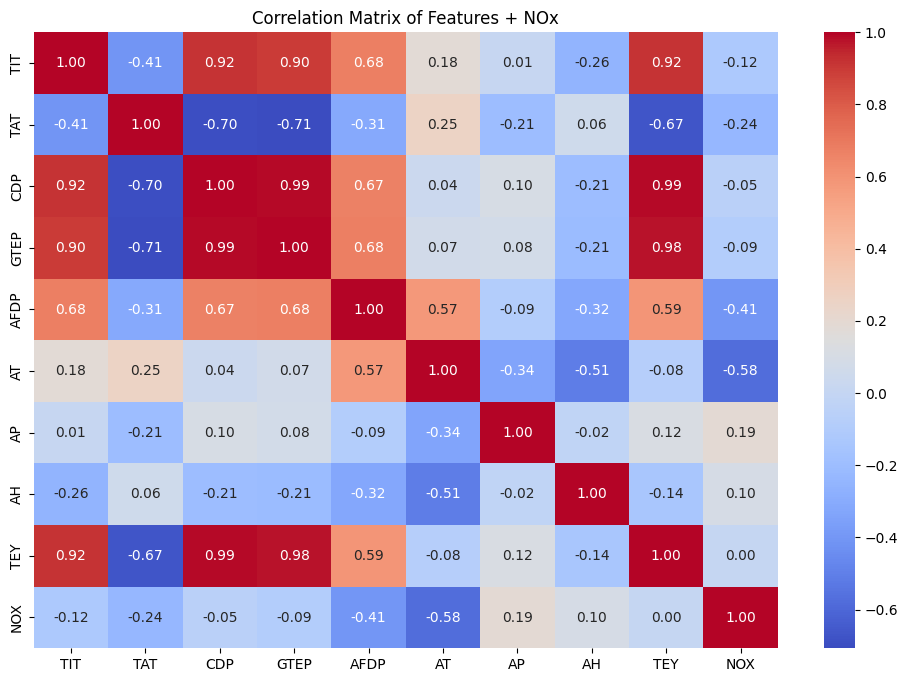

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(df[features + [target]].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features + NOx")
plt.show()


In [10]:
pair_scores = []

for i in range(len(features)):
    for j in range(i+1, len(features)):
        a, b = features[i], features[j]
        product = df[a] * df[b]
        corr = abs(product.corr(df[target]))
        pair_scores.append((f"{a}x{b}", corr))
        [k for k in pair_scores if "ATx" in k[0]][:10]

pair_scores = sorted(pair_scores, key=lambda x: x[1], reverse=True)
pair_scores[:15]  # show top 15 interactions


[('ATxAH', np.float64(0.631152980248483)),
 ('TATxAT', np.float64(0.5793621145584982)),
 ('ATxAP', np.float64(0.5762467892020999)),
 ('TITxAT', np.float64(0.5713530127721398)),
 ('CDPxAT', np.float64(0.5471017906909986)),
 ('ATxTEY', np.float64(0.5343222394789532)),
 ('AFDPxAT', np.float64(0.5327468921557416)),
 ('GTEPxAT', np.float64(0.5180574797658059)),
 ('TATxAFDP', np.float64(0.42786894856088153)),
 ('AFDPxAP', np.float64(0.4020247926419487)),
 ('TITxAFDP', np.float64(0.39048217362678406)),
 ('AFDPxAH', np.float64(0.31238594444127127)),
 ('CDPxAFDP', np.float64(0.3062262171929169)),
 ('TITxTAT', np.float64(0.30296011314558324)),
 ('AFDPxTEY', np.float64(0.2682385870455149))]

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import partial_dependence

# 1) Fit a RF model on the raw features (no interactions yet)
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=0,
    n_jobs=-1
)
rf.fit(df[features], df[target])

# 2) Choose candidate pairs based on product–NOx correlation from Cell B
#    pair_scores is a list like [("ATxAH", 0.63), ...]
top_k = 30   # you can increase to 30 if your machine is fine with it

candidate_pairs = [pair for pair, corr in pair_scores[:top_k]]
print("Number of candidate pairs for PDP:", len(candidate_pairs))
print(candidate_pairs[:10])

# 3) Compute PDP variance for each candidate pair
pdp_scores = []

for pair in candidate_pairs:
    a, b = pair.split("x")
    i = features.index(a)
    j = features.index(b)

    pdp = partial_dependence(
        rf,
        df[features],
        features=[(i, j)],
        grid_resolution=30
    )
    interaction_strength = np.var(pdp["average"])
    pdp_scores.append((pair, interaction_strength))

# 4) Inspect ranked interactions by PDP variance
pdp_scores_sorted = sorted(pdp_scores, key=lambda x: x[1], reverse=True)
pdp_scores_sorted[:30]

Number of candidate pairs for PDP: 30
['ATxAH', 'TATxAT', 'ATxAP', 'TITxAT', 'CDPxAT', 'ATxTEY', 'AFDPxAT', 'GTEPxAT', 'TATxAFDP', 'AFDPxAP']


[('TATxAT', np.float64(107.34457548353902)),
 ('ATxTEY', np.float64(53.138452930329954)),
 ('TATxAFDP', np.float64(53.119360441158754)),
 ('ATxAH', np.float64(49.31644281013534)),
 ('TITxAT', np.float64(43.67482229945761)),
 ('CDPxAT', np.float64(42.511755237897205)),
 ('ATxAP', np.float64(40.321266141188055)),
 ('GTEPxAT', np.float64(37.13229034582686)),
 ('AFDPxAT', np.float64(30.294146986303183)),
 ('AFDPxTEY', np.float64(22.74401510974912)),
 ('TITxAFDP', np.float64(20.70218933370882)),
 ('AFDPxAH', np.float64(12.612982848664522)),
 ('AFDPxAP', np.float64(12.294455783836518)),
 ('CDPxAFDP', np.float64(10.632381681007848)),
 ('GTEPxAFDP', np.float64(8.759692805099696)),
 ('TITxTAT', np.float64(7.110467021636826)),
 ('TITxAH', np.float64(6.098257441417072)),
 ('AHxTEY', np.float64(5.690006880366252)),
 ('TITxAP', np.float64(5.314418918413505)),
 ('TATxAH', np.float64(5.16149606998857)),
 ('TATxGTEP', np.float64(4.924400381416386)),
 ('TATxAP', np.float64(4.670230438623071)),
 ('TATxC

In [16]:
### ULTRA-FAST CELL D — SHAP interaction ranking via SHAP value products

import numpy as np
import shap

# 1) Small background set for efficiency
background = df[features].sample(300, random_state=42)

# 2) Compute SHAP values (not interaction values)
explainer = shap.TreeExplainer(rf)
shap_vals = explainer.shap_values(background)

# Convert to numpy array (n_samples x n_features)
shap_vals = np.array(shap_vals)

print("SHAP value matrix:", shap_vals.shape)

# 3) Evaluate SHAP interaction proxy for top PDP pairs only
top_n = 20
candidate_pairs = [pair for pair, score in pdp_scores_sorted[:top_n]]

interaction_strengths = {}

for pair in candidate_pairs:
    a, b = pair.split("x")
    i = features.index(a)
    j = features.index(b)

    # FAST proxy: |corr( SHAP(A), SHAP(B) )|
    strength = abs(np.corrcoef(shap_vals[:, i], shap_vals[:, j])[0, 1])
    interaction_strengths[pair] = strength

# 4) Rank the top interaction terms
sorted_interactions = sorted(interaction_strengths.items(), key=lambda x: x[1], reverse=True)

sorted_interactions[:30]


SHAP value matrix: (300, 9)


[('GTEPxAFDP', np.float64(0.5545640301161853)),
 ('AFDPxAT', np.float64(0.47192755085315874)),
 ('TITxTAT', np.float64(0.3882451615508497)),
 ('AFDPxAP', np.float64(0.3422552192067811)),
 ('CDPxAFDP', np.float64(0.30878235465573767)),
 ('GTEPxAT', np.float64(0.2831232999290274)),
 ('TATxAT', np.float64(0.2608428535834953)),
 ('ATxAP', np.float64(0.2122992013677456)),
 ('TITxAP', np.float64(0.2071185903838291)),
 ('ATxTEY', np.float64(0.20650652577350415)),
 ('AHxTEY', np.float64(0.20392619639553924)),
 ('TITxAH', np.float64(0.18363806177621975)),
 ('AFDPxTEY', np.float64(0.13052338048531928)),
 ('TATxAH', np.float64(0.11356401254403942)),
 ('CDPxAT', np.float64(0.09402857693438006)),
 ('AFDPxAH', np.float64(0.03914784752460422)),
 ('ATxAH', np.float64(0.032948182705144165)),
 ('TITxAT', np.float64(0.019188046901779447)),
 ('TATxAFDP', np.float64(0.014936194851327472)),
 ('TITxAFDP', np.float64(0.006497014883155255))]

In [17]:
### CELL E — Combine PDP scores + SHAP proxy to select final interactions

import pandas as pd

# Convert PDP scores to DataFrame
df_pdp = pd.DataFrame(pdp_scores_sorted, columns=["pair", "pdp"])
df_shap = pd.DataFrame(sorted_interactions, columns=["pair", "shap"])

# Merge by interaction pair
merged = df_pdp.merge(df_shap, on="pair")

# Normalize each score to [0,1]
merged["pdp_norm"]  = merged["pdp"]  / merged["pdp"].max()
merged["shap_norm"] = merged["shap"] / merged["shap"].max()

# Combined ranking:
# Weight SHAP slightly higher (model-aware), PDP still important
merged["combined"] = 0.45 * merged["shap_norm"] + 0.55 * merged["pdp_norm"]

# Sort by combined score
merged_sorted = merged.sort_values("combined", ascending=False)

# Show the top 12 interactions (usually ideal for model)
merged_sorted


,pair,pdp,shap,pdp_norm,shap_norm,combined
0,TATxAT,107.344575,0.260843,1.000000,0.470357,0.761660
8,AFDPxAT,30.294147,0.471928,0.282214,0.850988,0.538163
14,GTEPxAFDP,8.759693,0.554564,0.081603,1.000000,0.494882
1,ATxTEY,53.138453,0.206507,0.495027,0.372376,0.439834
7,GTEPxAT,37.132290,0.283123,0.345917,0.510533,0.419994
6,ATxAP,40.321266,0.212299,0.375625,0.382822,0.378863
15,TITxTAT,7.110467,0.388245,0.066240,0.700091,0.351473
12,AFDPxAP,12.294456,0.342255,0.114533,0.617161,0.340715
13,CDPxAFDP,10.632382,0.308782,0.099049,0.556802,0.305038
5,CDPxAT,42.511755,0.094029,0.396031,0.169554,0.294116


In [18]:
### CELL F — Select final interaction terms (top 8–12 ideal)

# Choose how many interactions to keep
TOP_K = 20    # you can increase to 10 or 12 if you want more complexity

# Extract top-K pairs from merged_sorted
final_pairs = merged_sorted.head(TOP_K)["pair"].tolist()

# Convert "A x B" → ("A", "B")
interactions = [(p.split("x")[0], p.split("x")[1]) for p in final_pairs]

print("Final interaction terms selected:")
interactions


Final interaction terms selected:


[('TAT', 'AT'),
 ('AFDP', 'AT'),
 ('GTEP', 'AFDP'),
 ('AT', 'TEY'),
 ('GTEP', 'AT'),
 ('AT', 'AP'),
 ('TIT', 'TAT'),
 ('AFDP', 'AP'),
 ('CDP', 'AFDP'),
 ('CDP', 'AT'),
 ('TAT', 'AFDP'),
 ('AT', 'AH'),
 ('TIT', 'AT'),
 ('AFDP', 'TEY'),
 ('TIT', 'AP'),
 ('AH', 'TEY'),
 ('TIT', 'AH'),
 ('TAT', 'AH'),
 ('TIT', 'AFDP'),
 ('AFDP', 'AH')]

In [20]:
interactions = [
    ('TAT', 'AT'),
    ('AFDP', 'AT'),
    ('GTEP', 'AFDP'),
    ('AT', 'TEY'),
    ('GTEP', 'AT'),
    ('AT', 'AP'),
    ('TIT', 'TAT'),
    ('AFDP', 'AP'),
    ('CDP', 'AFDP'),
    ('CDP', 'AT')
]


In [21]:
### UPDATED CELL 8 — Add final selected interactions to dataframe

# Clear any previous interaction columns
for a, b in interactions:
    col = f"{a}x{b}"
    if col in df.columns:
        del df[col]

# Create final interaction columns
for a, b in interactions:
    df[f"{a}x{b}"] = df[a] * df[b]

# Build final feature set
X_cols = features + [f"{a}x{b}" for a, b in interactions]

X = df[X_cols]
y = df[target]

print("Final feature matrix shape:", X.shape)
print("Final interaction terms:", [f"{a}x{b}" for a, b in interactions])


Final feature matrix shape: (14310, 19)
Final interaction terms: ['TATxAT', 'AFDPxAT', 'GTEPxAFDP', 'ATxTEY', 'GTEPxAT', 'ATxAP', 'TITxTAT', 'AFDPxAP', 'CDPxAFDP', 'CDPxAT']


In [23]:
### FIXED CELL 9 — Stable ElasticNet with full convergence

from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

enet_full = Pipeline([
    ("scaler", StandardScaler()),
    ("enet", ElasticNetCV(
        cv=5,
        l1_ratio=[0.3, 0.5, 0.7],          # avoid unstable extremes
        alphas=np.logspace(-3, 2, 20),     # stronger regularization grid
        max_iter=200000,                   # allow optimizer to fully converge
        tol=1e-3,                          # relax tolerance for stability
        n_jobs=-1,
        random_state=42
    ))
])

enet_full.fit(X, y)

import joblib
joblib.dump(enet_full, "model_full.pkl")

print("ElasticNet (stable version) trained and saved.")


ElasticNet (stable version) trained and saved.


# NOx Tuning – Recommendation Reference Guide

This guide lists all recommendations used in the model logic, plus extra
interaction-based insights. All definitions are simplified for non-engineers.

---

## 🔵 1. General Recommendations (Direct Model Rules)

### **AFDP_HIGH — “Inlet filters may be restrictive.”**
Clogged/dirty filters → clean or replace.

### **AFDP_NOX_UP — “Check pre-filters / inlet leaks.”**
If AFDP is high AND NOx rises → inlet leak or heavy blockage likely.

### **TIT_HIGH — “Reduce TIT a step; re-balance fuel–air.”**
Burn temperature slightly too high.

### **TAT_RISING — “Check combustor spread and trims.”**
Burning unevenly → adjust trim values.

### **CDP_OFF — “Inspect IGVs/bleeds; check compressor fouling.”**
Air compression low or unstable → inspect compressor.

### **GTEP_HIGH — “Inspect stack/ducts/silencers; remove back-pressure.”**
Exhaust path may be restricted.

### **AT_EXTREME — “Small TIT/TAT retune for ambient.”**
Hot/cold weather is changing emissions.

### **AP_LOW — “Expect small drift; focus on airflow health.”**
Low atmospheric pressure → minor performance drift.

### **AH_HIGH — “Verify water/steam injection setpoints.”**
Too much humidity → verify injection limits.

### **BAND_MISMATCH — “Switch to correct load-band model.”**
Using wrong statistical model for current load.

### **LARGE_JUMP — “Undo last change; recheck sensors.”**
A sudden NOx change with tiny input change.

### **SENSOR_OUTLIER — “Do not tune on bad sensor data.”**
One sensor likely faulty → confirm before tuning.

### **POST_MAINTENANCE — “Re-run prediction and compare.”**
After maintenance → emissions need a second check.

### **MULTIPLE_DRIVERS — “Change one lever at a time.”**
Too many variables moving → adjust slowly.

### **PRIORITY_LEVERS — “AFDP → TIT/TAT → GTEP → CDP.”**
Order of tuning impact (highest → lowest).

### **OUT_OF_RANGE — “Inputs outside model range.”**
Unexpected values → prediction less trustworthy.

### **WEATHER_ONLY — “Weather-driven drift; prefer scheduling.”**
If only outside weather changed → tuning not needed.

### **NOX_DOWN_CO_UP — “Too lean; back off previous change.”**
Low NOx but high CO = unbalanced fuel mix.

---

## 🟣 2. Interaction-Term–Based Recommendations  
These link **two variables together**.  
Useful when NOx rises only when *both* parameters change simultaneously.

### **TAT × AT — High TAT + high ambient heat**
Machine + weather both hot → burning less efficiently.
→ *Do a small TIT/TAT trim; avoid high load in peak heat.*

### **AFDP × AT — Filters struggle more in high heat**
Hot air lowers density; filters feel “heavier.”
→ *Inspect filters sooner on hot days.*

### **GTEP × AFDP — Exhaust + Inlet restriction together**
Both intake and exhaust paths strained.
→ *Check inlet filters AND stack/ducts together.*

### **AT × TEY — High ambient heat + mid-range load**
Weather impacts emissions more at mid-range load.
→ *Avoid holding long in mid-load bands during hot days.*

### **GTEP × AT — Hot air + exhaust backpressure**
Hot air expands → higher exhaust resistance.
→ *Clean silencers; reduce TIT slightly.*

### **AT × AP — Hot + low pressure day**
Bad weather combination; airflow reduces significantly.
→ *Expect NOx rise; tune only if persistent.*

### **TIT × TAT — High flame + high post-flame temperature**
Burning very hot throughout the combustor.
→ *Re-balance fuel distribution.*

### **AFDP × AP — High filter pressure + low external pressure**
Air struggling to enter turbine.
→ *Filters near end-of-life; inspect.*

### **CDP × AFDP — Low compressor pressure + high filter drop**
Strong sign of inlet blockage.
→ *High priority → inspect filters immediately.*

### **CDP × AT — Compressor pressure sensitive to heat**
Hot weather lowers compression efficiency.
→ *Lower load or trim TIT slightly.*

---

## 🟢 3. Layman Understanding Summary  
(One-line for technicians or non-engineers)

- **AFDP issues** → Clean filters. Check for dust, blockage, or leaks.  
- **TIT/TAT issues** → Temperatures too high → reduce heat slightly.  
- **CDP issues** → Compressor dirty → needs cleaning.  
- **GTEP issues** → Exhaust blocked → clean stack/silencer.  
- **Ambient interactions** → Hot/humid/thin air increases NOx.  
- **Multiple issues** → Fix in this order:  
  **Filters → Temperatures → Exhaust → Compressor.**  
- **Sensor issues** → Don’t tune until sensors are checked.  
- **Weather-only changes** → Don’t tune; performance will return.  
- **Load-band mismatch** → Use correct model for current load.

---

## 🟡 4. Priority Order for Fixing NOx
**1. AFDP (Filters / Inlet)**  
**2. TIT / TAT (Combustion Temps)**  
**3. GTEP (Exhaust Backpressure)**  
**4. CDP (Compressor Health)**  

---

